![image](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)
# Use watsonx, and `mistralai/mistral-large` with support for tools to perform simple calculations

#### Disclaimers

- Use only Projects and Spaces that are available in watsonx context.


## Notebook content

This notebook provides a detailed demonstration of the steps and code required to showcase support for Chat models, including the integration of tools using [LangGraph](https://langchain-ai.github.io/langgraph/) and watsonx.ai models.

Some familiarity with Python is helpful. This notebook uses Python 3.11.


## Learning goal

The purpose of this notebook is to demonstrate how to use Chat models, e.g. `mistralai/mistral-large` using the tools available in LangGraph. LangGraph is an Agent Orchestrator with which you can build graph applications that automatically execute sequences of actions and in which the LLM is the key decision maker that determines the next step.


## Table of Contents

This notebook contains the following parts:

- [Setup](#setup)
- [Foundation Models on watsonx](#models)
- [LangChain integration](#chatwatsonx)
- [Example](#example)
- [Summary](#summary)

<a id="setup"></a>
## Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://cloud.ibm.com/catalog/services/watsonxai-runtime" target="_blank" rel="noopener no referrer">watsonx.ai Runtime Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/wml-plans.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">here</a>).

### Install and import the `datasets` and dependencies

In [ ]:
!pip install -U "langgraph>0.2,<0.3" | tail -n 1
!pip install -U "langchain_ibm>=0.3,<0.4" | tail -n 1

### Define the watsonx.ai credentials
Use the code cell below to define the watsonx.ai credentials that are required to work with watsonx Foundation Model inferencing.

**Action:** Provide the IBM Cloud user API key. For details, see <a href="https://cloud.ibm.com/docs/account?topic=account-userapikey&interface=ui" target="_blank" rel="noopener no referrer">Managing user API keys</a>.

In [2]:
import getpass
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    url="https://us-south.ml.cloud.ibm.com",
    api_key=getpass.getpass("Enter your watsonx.ai api key and hit enter: "),
)

### Define the project ID
You need to provide the project ID to give the Foundation Model the context for the call. If you have a default project ID set in Watson Studio, the notebook obtains that project ID. Otherwise, you need to provide the project ID in the code cell below.

In [3]:
import os

try:
    project_id = os.environ["PROJECT_ID"]
except KeyError:
    project_id = input("Enter your project_id and hit enter: ")

<a id="models"></a>
## Set up a Foundation Model on `watsonx.ai`


Specify the `model_id` of the model you will use for the chat with tools.

In [2]:
model_id = "mistralai/mistral-large"

<a id="chatwatsonx"></a>
## LangChain integration

`ChatWatsonx` is a wrapper around watsonx.ai models that provides chat integration around the models.

### Initialize the `ChatWatsonx` class

In [3]:
from langchain_ibm import ChatWatsonx

chat = ChatWatsonx(
    url=credentials["url"],
    apikey=credentials["apikey"],
    model_id=model_id,
    project_id=project_id,
)

Next, define the assistant's tools to make a calculation.

In [5]:
from langchain_core.tools import tool

@tool
def add(a: float, b: float) -> float:
    """Add a and b."""
    return a + b

@tool
def subtract(a: float, b: float) -> float:
    """Subtract a and b."""
    return a - b

@tool
def multiply(a: float, b: float) -> float:
    """Multiply a and b."""
    return a * b

@tool
def divide(a: float, b: float) -> float:
    """Divide a and b."""
    return a / b


tools = [add, subtract, multiply, divide]

Define the graph.

In [6]:
from langgraph.prebuilt import create_react_agent

graph = create_react_agent(chat, tools=tools)

Visualize the graph you just created.

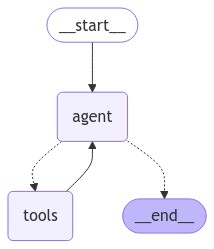

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Add a helpful function to print messages from the model.

In [8]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

<a id="example"></a>
## Example

Run the app with an input that needs a tool call.

In [9]:
inputs = {"messages": [("user", "What is the total sum of the numbers 11, 13, and 20?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the total sum of the numbers 11, 13, and 20?
================================== Ai Message ==================================
Tool Calls:
  add (chatcmpl-tool-89f2b4a84b1740788d03c41fc1eee972)
 Call ID: chatcmpl-tool-89f2b4a84b1740788d03c41fc1eee972
  Args:
    a: 11
    b: 13
  add (chatcmpl-tool-c68fcc481d4d4f518094b10bc00c8b02)
 Call ID: chatcmpl-tool-c68fcc481d4d4f518094b10bc00c8b02
  Args:
    a: 24
    b: 20
================================= Tool Message =================================
Name: add

44.0
================================== Ai Message ==================================

 The total sum of the numbers 11, 13, and 20 is 44.


In [10]:
inputs = {"messages": [("user", "What is the result when 81 is subtracted from 100?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the result when 81 is subtracted from 100?
================================== Ai Message ==================================
Tool Calls:
  subtract (chatcmpl-tool-d8cd23faaf1b483ea5cc321fb7ef54f7)
 Call ID: chatcmpl-tool-d8cd23faaf1b483ea5cc321fb7ef54f7
  Args:
    a: 100
    b: 81
================================= Tool Message =================================
Name: subtract

19.0
================================== Ai Message ==================================

 The result when 81 is subtracted from 100 is 19.


In [11]:
inputs = {"messages": [("user", "Calculate the result of multiplying 10 by 12.")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Calculate the result of multiplying 10 by 12.
================================== Ai Message ==================================
Tool Calls:
  multiply (chatcmpl-tool-4c6f1ce212b2486f97245d1be548ef4d)
 Call ID: chatcmpl-tool-4c6f1ce212b2486f97245d1be548ef4d
  Args:
    a: 10
    b: 12
================================= Tool Message =================================
Name: multiply

120.0
================================== Ai Message ==================================

 The result of multiplying 10 by 12 is 120.


In [12]:
inputs = {"messages": [("user", "Determine the result of dividing 2 by 3.")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Determine the result of dividing 2 by 3.
================================== Ai Message ==================================
Tool Calls:
  divide (chatcmpl-tool-523693382d654c2abb3ce927890a6a0e)
 Call ID: chatcmpl-tool-523693382d654c2abb3ce927890a6a0e
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: divide

0.6666666666666666
================================== Ai Message ==================================

 The result of dividing 2 by 3 is approximately 0.67.


In [13]:
inputs = {"messages": [("user", "What is the result when the sum of 2 and 3 is multiplied by 6 and then divided by 10?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the result when the sum of 2 and 3 is multiplied by 6 and then divided by 10?
================================== Ai Message ==================================
Tool Calls:
  add (chatcmpl-tool-0848576754c741fda9df501b3ab4dfa1)
 Call ID: chatcmpl-tool-0848576754c741fda9df501b3ab4dfa1
  Args:
    a: 2
    b: 3
  multiply (chatcmpl-tool-e885f329df664cf9834ff08ae2a61934)
 Call ID: chatcmpl-tool-e885f329df664cf9834ff08ae2a61934
  Args:
    a: 5
    b: 6
  divide (chatcmpl-tool-66de60e8cc834d2ba5119dfcb462e415)
 Call ID: chatcmpl-tool-66de60e8cc834d2ba5119dfcb462e415
  Args:
    a: 30
    b: 10
================================= Tool Message =================================
Name: divide

3.0
================================== Ai Message ==================================

 The result is 3.0


<a id="summary"></a>
## Summary and next steps

You successfully completed this notebook!

You learned how to build a simple graph using LangGraph and `ChatWatsonx`.

Check out our _<a href="https://ibm.github.io/watsonx-ai-python-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Author

**Mateusz Szewczyk**, Software Engineer at watsonx.ai.

Copyright © 2024-2025 IBM. This notebook and its source code are released under the terms of the MIT License.